In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
      --------------------------------------- 0.1/5.0 MB 5.1 MB/s eta 0:00:01
     --- ------------------------------------ 0.5/5.0 MB 4.9 MB/s eta 0:00:01
     ------ --------------------------------- 0.8/5.0 MB 7.0 MB/s eta 0:00:01
     ------ --------------------------------- 0.8/5.0 MB 7.0 MB/s eta 0:00:01
     ------------ --------------------------- 1.6/5.0 MB 8.0 MB/s eta 0:00:01
     ------------ --------------------------- 1.6/5.0 MB 8.0 MB/s eta 0:00:01
     ----------------- ---------------------- 2.2/5.0 MB 7.4 MB/s eta 0:00:01
     ------------------- -------------------- 2.5/5.0 MB 7.5 MB/s eta 0:00:01
     ------------------------ --------------- 3.1/5.0 MB 7.6 MB/s eta 0:00:01
     -------------------------- ------------- 3.4/5.0 MB 8.0 MB/s eta 0:00:01
     ---------------------------------- ----- 4.3/5.0 MB 8.9 MB/s eta 0:00:01
     -------

In [2]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset
from torch import cuda
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = 'cuda' if cuda.is_available() else 'cpu'

d:\Web_Automation\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#chapter-> Class
#Question-> Sender+subject+content

In [5]:
ROOT_DIR = 'emails.csv' 
df_org= pd.read_csv(ROOT_DIR)
df_org.dropna(inplace=True)
df_org['Class'] = df_org['Class'].astype(int)
df_org["labels"]=df_org['Class']
df_org['Class'] = df_org['Class'].astype(str)  # Ensure that Class is a string
df_org.loc[df_org['Class'] == '1', 'Class'] = 'recruitment mail'
df_org.loc[df_org['Class'] == '0', 'Class'] = 'non-recruitment mail'
labels = [0, 1]
NUM_LABELS = 2
id2label = {0: 'non-recruitment mail', 1: 'recruitment mail'}
label2id = {'non-recruitment mail': 0, 'recruitment mail': 1}
df_org.head()


,Sender,Subject,Content,Link,Class,labels
1,Dean Saharanpur,A fake ID (in my name: SUJAY CHATTOPADHYAY) is...,Dean Saharanpur A fake ID (in my name: SUJAY C...,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,non-recruitment mail,0
3,CS Pant,Request to please bring your calculator and la...,CS Pant Request to please bring your calculato...,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,non-recruitment mail,0
5,General Secretary Technical Affairs,Tinkering Lab: Software Developer Recruitment,"General, SASMIT 3 Tinkering Lab: Software Dev...",https://mail.google.com/mail/u/0/#inbox/FMfcgz...,recruitment mail,1
7,General Secretary Technical Affairs,Enactus IIT-Roorkee || Recruitments for UG Des...,"Gener., me, SASMIT 4 Enactus IIT-Roorkee || R...",https://mail.google.com/mail/u/0/#inbox/FMfcgz...,recruitment mail,1
9,NCC IIT Roorkee,Join NCC IIT Roorkee - Cadet Recruitment Drive!,"NCC .. Mail, SASMIT 5 Join NCC IIT Roorkee - ...",https://mail.google.com/mail/u/0/#inbox/FMfcgz...,recruitment mail,1


In [6]:
df_org['labels'][7]

1

<Axes: ylabel='count'>

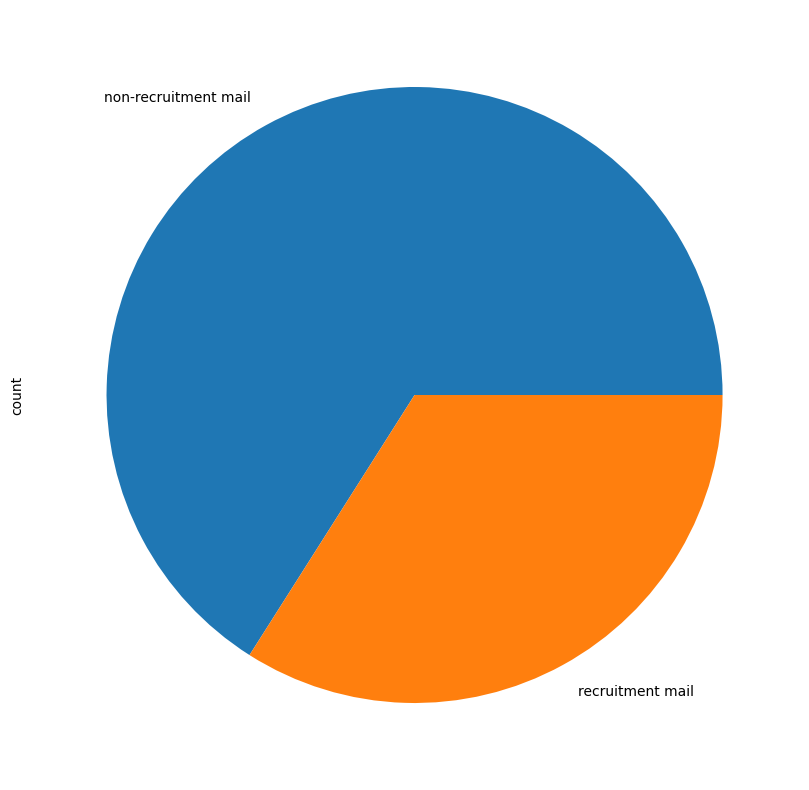

In [7]:

df_org.Class.value_counts().plot(kind='pie', figsize=(10,10))

In [8]:
NUM_LABELS

2

In [9]:
df_org['Combined'] = df_org['Sender'] + ' ' + df_org['Subject'] + ' ' + df_org['Content']
df_org.head()

,Sender,Subject,Content,Link,Class,labels,Combined
1,Dean Saharanpur,A fake ID (in my name: SUJAY CHATTOPADHYAY) is...,Dean Saharanpur A fake ID (in my name: SUJAY C...,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,non-recruitment mail,0,Dean Saharanpur A fake ID (in my name: SUJAY C...
3,CS Pant,Request to please bring your calculator and la...,CS Pant Request to please bring your calculato...,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,non-recruitment mail,0,CS Pant Request to please bring your calculato...
5,General Secretary Technical Affairs,Tinkering Lab: Software Developer Recruitment,"General, SASMIT 3 Tinkering Lab: Software Dev...",https://mail.google.com/mail/u/0/#inbox/FMfcgz...,recruitment mail,1,General Secretary Technical Affairs Tinkering ...
7,General Secretary Technical Affairs,Enactus IIT-Roorkee || Recruitments for UG Des...,"Gener., me, SASMIT 4 Enactus IIT-Roorkee || R...",https://mail.google.com/mail/u/0/#inbox/FMfcgz...,recruitment mail,1,General Secretary Technical Affairs Enactus II...
9,NCC IIT Roorkee,Join NCC IIT Roorkee - Cadet Recruitment Drive!,"NCC .. Mail, SASMIT 5 Join NCC IIT Roorkee - ...",https://mail.google.com/mail/u/0/#inbox/FMfcgz...,recruitment mail,1,NCC IIT Roorkee Join NCC IIT Roorkee - Cadet R...


In [16]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)
SIZE= df_org.shape[0]
train_texts= list(df_org.Combined[:(7*SIZE)//10])
val_texts=   list(df_org.Combined[(7*SIZE)//10:(17*SIZE)//20 ])
test_texts=  list(df_org.Combined[(17*SIZE)//20:])
train_labels= list(df_org.labels[:(7*SIZE)//10])
val_labels=   list(df_org.labels[(7*SIZE)//10:(17*SIZE)//20])
test_labels=  list(df_org.labels[(17*SIZE)//20:])

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

d:\Web_Automation\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
len(val_texts)

7

In [18]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [19]:
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataset = DataLoader(test_encodings, test_labels)

In [20]:
def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [21]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=50,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

d:\Web_Automation\venv\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

d:\Web_Automation\venv\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [23]:
trainer.train()

  0%|          | 0/150 [00:00<?, ?it/s]d:\Web_Automation\venv\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 33%|███▎      | 50/150 [00:09<00:17,  5.67it/s]

{'loss': 0.4807, 'grad_norm': 3.6388027667999268, 'learning_rate': 2.4e-05, 'epoch': 16.67}


d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                
 34%|███▍      | 51/15

{'eval_loss': 0.084272101521492, 'eval_Accuracy': 1.0, 'eval_F1': 0.0, 'eval_Precision': 0.0, 'eval_Recall': 0.0, 'eval_runtime': 0.0442, 'eval_samples_per_second': 158.358, 'eval_steps_per_second': 22.623, 'epoch': 16.67}


 67%|██████▋   | 100/150 [00:18<00:08,  6.09it/s]

{'loss': 0.0271, 'grad_norm': 0.03562484309077263, 'learning_rate': 4.9e-05, 'epoch': 33.33}


d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
 67%|██████▋   | 101/

{'eval_loss': 0.0007482938235625625, 'eval_Accuracy': 1.0, 'eval_F1': 0.0, 'eval_Precision': 0.0, 'eval_Recall': 0.0, 'eval_runtime': 0.0337, 'eval_samples_per_second': 207.725, 'eval_steps_per_second': 29.675, 'epoch': 33.33}


100%|██████████| 150/150 [00:26<00:00,  5.76it/s]

{'loss': 0.0007, 'grad_norm': 0.018259672448039055, 'learning_rate': 2.0000000000000003e-06, 'epoch': 50.0}


d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Web_Automation\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
100%|██████████| 150/

{'eval_loss': 0.0003686632844619453, 'eval_Accuracy': 1.0, 'eval_F1': 0.0, 'eval_Precision': 0.0, 'eval_Recall': 0.0, 'eval_runtime': 0.0333, 'eval_samples_per_second': 210.438, 'eval_steps_per_second': 30.063, 'epoch': 50.0}


100%|██████████| 150/150 [00:35<00:00,  4.28it/s]

{'train_runtime': 35.0872, 'train_samples_per_second': 49.876, 'train_steps_per_second': 4.275, 'train_loss': 0.1695136851320664, 'epoch': 50.0}


TrainOutput(global_step=150, training_loss=0.1695136851320664, metrics={'train_runtime': 35.0872, 'train_samples_per_second': 49.876, 'train_steps_per_second': 4.275, 'total_flos': 120506918910000.0, 'train_loss': 0.1695136851320664, 'epoch': 50.0})

In [24]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader]]

pd.DataFrame(q, index=["train"]).iloc[:,:5]

100%|██████████| 2/2 [00:00<00:00, 42.63it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.000463,1.0,1.0,1.0,1.0


In [25]:
model.to(device)
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

    # Get model output (logits)
    outputs = model(**inputs.to(device))

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [26]:
text = "General, RONIT  2 Recruitment Announcement - ARIES for 1st year Attachment: Instagram post - 15 (2).png 1:39â€¯PM"
predict(text)

(tensor([[7.4225e-04, 9.9926e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(1, device='cuda:0'),
 'recruitment mail')

In [27]:
model_path = "saved models/bert-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('saved models/bert-classification-model\\tokenizer_config.json',
 'saved models/bert-classification-model\\special_tokens_map.json',
 'saved models/bert-classification-model\\vocab.txt',
 'saved models/bert-classification-model\\added_tokens.json',
 'saved models/bert-classification-model\\tokenizer.json')

In [30]:
model_path = "saved models/bert-classification-model"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
Model= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [31]:
Model("General, RONIT  2 Recruitment Announcement - ARIES for 1st year Attachment: Instagram post - 15 (2).png 1:39â€¯PM")


[{'label': 'recruitment mail', 'score': 0.9992581009864807}]

In [ ]:
df_org